# Development notebook

Using this notebook to do the following:
1. learn how to use mctx
2. test my edits fror mctx -> thtx
3. ramble/journal/vent?
4. apologise if anyone ever reads this, because I am hacking this all together between thesis writing sessions.

## Notes 
- 18/10/24 - decided to keep mctx in its own folder, and then implement thtx in a new folder. This way can make THTS a clean implementation rather than just hacked in. If this gets released, can delete this notebook and mctx folder in main branch, and keep it in a backup dev branch
- 18/10/24 - actually, fuck it, three folders. folder1 = mctx, immutable; folder2 = mctx_play, where I hack things into mctx; folder3 = thtx, clean impl of thtx
- 18/10/24 - ooops, just realised, might as well use mctx installed through pip as clean copy, mctx as the hacking folder, and thtx as clean

## Part 0: Setup being able to use thtx repo in this notebook

https://medium.com/@pablosjv/importing-local-python-modules-into-jupyter-notebooks-87336b2d7746

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath('/home/michael/Desktop/thtx') # or the path to your source code
sys.path.insert(0, module_path)

In [2]:
# Test import
from mctx._src.tree import Tree

## Part 1: Working through connect 4 example

#### 1.1 copying out the game definitions

Deleting all the comments to make it more concise. Go look at original if wan understand

In [3]:
import chex
from rich import print
import jax.numpy as jnp

Board = chex.Array
Action = chex.Array
Player = chex.Array
Reward = chex.Array
Done = chex.Array

@chex.dataclass
class Env:
    board: Board
    player: Player
    done: Done
    reward: Reward

BOARD_STRING = """
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 1   2   3   4   5   6   7
"""

def print_board(board: Board):
    board_str = BOARD_STRING
    for i in reversed(range(board.shape[0])):
        for j in range(board.shape[1]):
            board_str = board_str.replace('?', '[green]X[/green]' if board[i, j] == 1 else '[red]O[/red]' if board[i, j] == -1 else ' ', 1)
    print(board_str)

def horizontals(board: Board) -> chex.Array:
    return jnp.stack([
        board[i, j:j+4]
        for i in range(board.shape[0])
        for j in range(board.shape[1] - 3)
    ])

def verticals(board: Board) -> chex.Array:
    return jnp.stack([
        board[i:i+4, j]
        for i in range(board.shape[0] - 3)
        for j in range(board.shape[1])
    ])

def diagonals(board: Board) -> chex.Array:
    return jnp.stack([
        jnp.diag(board[i:i+4, j:j+4])
        for i in range(board.shape[0] - 3)
        for j in range(board.shape[1] - 3)
    ])

def antidiagonals(board: Board) -> chex.Array:
    return jnp.stack([
        jnp.diag(board[i:i+4, j:j+4][::-1])
        for i in range(board.shape[0] - 3)
        for j in range(board.shape[1] - 3)
    ])

def get_winner(board: Board) -> Player:
    all_lines = jnp.concatenate((
        horizontals(board),
        verticals(board),
        diagonals(board),
        antidiagonals(board),
    ))
    x_won = jnp.any(jnp.all(all_lines == 1, axis=1)).astype(jnp.int8)
    o_won = jnp.any(jnp.all(all_lines == -1, axis=1)).astype(jnp.int8)
    return x_won - o_won

def env_reset(_):
    return Env(
        board=jnp.zeros((6, 7), dtype=jnp.int8),
        player=jnp.int8(1),
        done=jnp.bool_(False),
        reward=jnp.int8(0),
    )

def env_step(env: Env, action: Action) -> tuple[Env, Reward, Done]:
    col = action
    row = jnp.argmax(env.board[:, col] == 0)
    invalid_move = env.board[row, col] != 0
    board = env.board.at[row, col].set(jnp.where(env.done | invalid_move, env.board[row, col], env.player))
    reward = jnp.where(env.done, 0, jnp.where(invalid_move, -1, get_winner(board) * env.player)).astype(jnp.int8)
    done = env.done | reward != 0 | invalid_move | jnp.all(board[-1] != 0)
    env = Env(
        board=board,
        # switch player
        player=jnp.where(done, env.player, -env.player),
        done=done,
        reward=reward,
    )
    return env, reward, done

#### 1.2 Policy stuff

In [4]:
def valid_action_mask(env: Env) -> chex.Array:
    return jnp.where(env.done, jnp.array([False] * env.board.shape[1]), env.board[-1] == 0)
    
def winning_action_mask(env: Env, player: Player) -> chex.Array:
    env = Env(board=env.board, player=player, done=env.done, reward=env.reward)
    env, reward, done = jax.vmap(env_step, (None, 0))(env, jnp.arange(7, dtype=jnp.int8))
    return reward == 1

def policy_function(env: Env) -> chex.Array:
    return sum((
        valid_action_mask(env).astype(jnp.float32) * 100,
        winning_action_mask(env, -env.player).astype(jnp.float32) * 200,
        winning_action_mask(env, env.player).astype(jnp.float32) * 300,
    ))

#### 1.3 Classic MCTS stuff

In [5]:
import jax
import mctx
import functools

def rollout(env: Env, rng_key: chex.PRNGKey) -> Reward:
    def cond(a):
        env, key = a
        return ~env.done
    def step(a):
        env, key = a
        key, subkey = jax.random.split(key)
        action = jax.random.categorical(subkey, policy_function(env))
        env, reward, done = env_step(env, action)
        return env, key
    leaf, key = jax.lax.while_loop(cond, step, (env, rng_key))
    return leaf.reward * leaf.player * env.player

def value_function(env: Env, rng_key: chex.PRNGKey) -> chex.Array:
    return rollout(env, rng_key).astype(jnp.float32)

def root_fn(env: Env, rng_key: chex.PRNGKey) -> mctx.RootFnOutput:
    return mctx.RootFnOutput(
        prior_logits=policy_function(env),
        value=value_function(env, rng_key),
        # We will use the `embedding` field to store the environment.
        embedding=env,
    )

def recurrent_fn(params, rng_key, action, embedding):
    env = embedding
    env, reward, done = env_step(env, action)
    recurrent_fn_output = mctx.RecurrentFnOutput(
        reward=reward,
        discount=jnp.where(done, 0, -1).astype(jnp.float32),
        prior_logits=policy_function(env),
        value=jnp.where(done, 0, value_function(env, rng_key)).astype(jnp.float32),
    )
    return recurrent_fn_output, env

@functools.partial(jax.jit, static_argnums=(2,))
def run_mcts(rng_key: chex.PRNGKey, env: Env, num_simulations: int) -> chex.Array:
    batch_size = 1
    key1, key2 = jax.random.split(rng_key)
    policy_output = mctx.muzero_policy(
        params=None,
        rng_key=key1,
        root=jax.vmap(root_fn, (None, 0))(env, jax.random.split(key2, batch_size)),
        recurrent_fn=jax.vmap(recurrent_fn, (None, None, 0, 0)),
        num_simulations=num_simulations,
        max_depth=42,
        qtransform=functools.partial(mctx.qtransform_by_min_max, min_value=-1, max_value=1),
        dirichlet_fraction=0.0,
    )
    return policy_output

#### 1.4 Running some stuff

Copying the "play twice in the middle collumn" and see what mcts does bit

In [6]:
import matplotlib.pyplot as plt

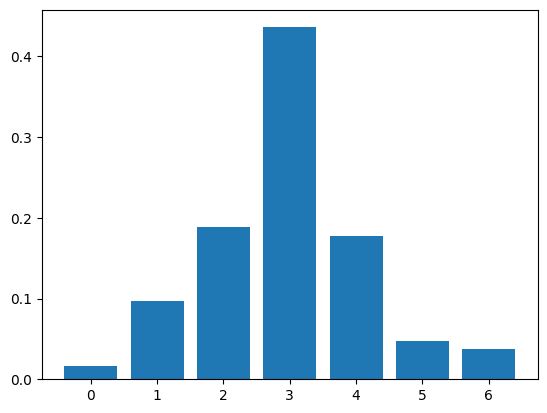

In [7]:
env = env_reset(0)
env, reward, done = env_step(env, 3)
env, reward, done = env_step(env, 3)
policy_output = run_mcts(jax.random.PRNGKey(0), env, 1000)
plt.bar(jnp.arange(7), policy_output.action_weights.mean(axis=0))
plt.show()

#### My Turn :)

First, why did we play two moves, why not see where it wants to go on first move? Middle is best no?

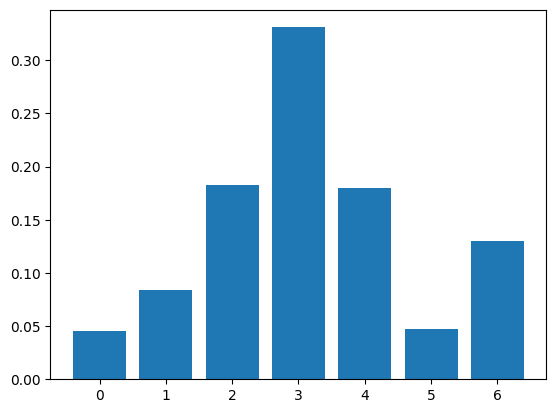

CPU times: user 1.15 s, sys: 114 ms, total: 1.26 s
Wall time: 1.13 s


In [8]:
%%time
env = env_reset(0)
policy_output = run_mcts(jax.random.PRNGKey(0), env, 1000)
plt.bar(jnp.arange(7), policy_output.action_weights.mean(axis=0))
plt.show()

Ok sure, just not as clean of a gaussian distr. Ok, lets look at what policy_output actually is

In [9]:
policy_output

PolicyOutput(action=Array([3], dtype=int32), action_weights=Array([[0.045     , 0.08400001, 0.18300001, 0.33100003, 0.18      ,
        0.047     , 0.13000001]], dtype=float32), search_tree=Tree(node_visits=Array([[1001,  180,  183, ...,    1,    1,    1]], dtype=int32), raw_values=Array([[-1.,  1.,  1., ...,  1.,  1., -1.]], dtype=float32), node_values=Array([[ 0.0619383 , -0.07777785, -0.08196725, ...,  1.        ,
         1.        , -1.        ]], dtype=float32), parents=Array([[ -1,   0,   0, ..., 988, 997, 287]], dtype=int32), action_from_parent=Array([[-1,  4,  2, ...,  6,  1,  1]], dtype=int32), children_index=Array([[[  3,   5,   2, ...,   1,  21,  23],
        [391, 139, 411, ..., 413, 416, 414],
        [ 62,  59,  64, ...,  60,  61,  63],
        ...,
        [ -1,  -1,  -1, ...,  -1,  -1,  -1],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1]]], dtype=int32), children_prior_logits=Array([[[ -1.9459101,  -1.9459101,  -1.9459101, ...,

In [10]:
policy_output.action

Array([3], dtype=int32)

In [11]:
policy_output.action_weights

Array([[0.045     , 0.08400001, 0.18300001, 0.33100003, 0.18      ,
        0.047     , 0.13000001]], dtype=float32)

In [12]:
policy_output.search_tree.node_visits

Array([[1001,  180,  183, ...,    1,    1,    1]], dtype=int32)

In [13]:
policy_output.search_tree.node_visits.shape

(1, 1001)

Ok, so I also wanted to try write some sort of iterator over the tree. Or see that it is possible. 

Next up, what is that functools partial thing doing?

In [14]:
def bad_mcts(rng_key: chex.PRNGKey, env: Env, num_simulations: int) -> chex.Array:
    batch_size = 1
    key1, key2 = jax.random.split(rng_key)
    policy_output = mctx.muzero_policy(
        params=None,
        rng_key=key1,
        root=jax.vmap(root_fn, (None, 0))(env, jax.random.split(key2, batch_size)),
        recurrent_fn=jax.vmap(recurrent_fn, (None, None, 0, 0)),
        num_simulations=num_simulations,
        max_depth=42,
        qtransform=functools.partial(mctx.qtransform_by_min_max, min_value=-1, max_value=1),
        dirichlet_fraction=0.0,
    )
    return policy_output

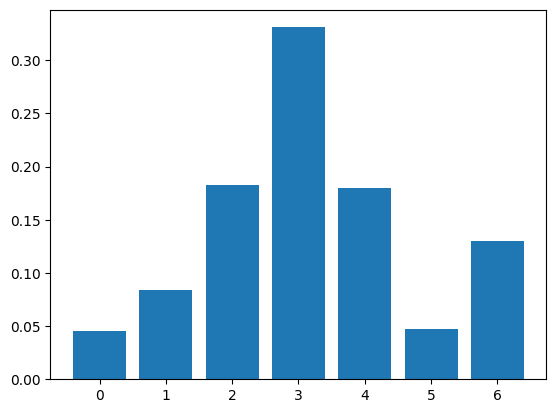

CPU times: user 10.7 s, sys: 286 ms, total: 11 s
Wall time: 10.2 s


In [15]:
%%time
env = env_reset(0)
policy_output = bad_mcts(jax.random.PRNGKey(0), env, 1000)
plt.bar(jnp.arange(7), policy_output.action_weights.mean(axis=0))
plt.show()

After learning a bit of googling about functools partial (https://docs.python.org/3/library/functools.html) and somehow vaguely understanding what decorators actually do (from https://stackoverflow.com/questions/48098569/use-of-functools-partial-in-a-decorator-that-attaches-function-as-attribute-of-o) realised that it's just applying jax.jit to the function. As can be seen by it being 8x slower without the decorator

## Part 2: Foundations

18/10/24 - Finishing for today, after writing this block with some thoughts on what to do next

So, feel comfortable with this stuff now, as had MCTX code open while working through connect 4 example. 

Next thing to do is work out how to do growing arrays in jax

MCTX can use the number of nodes $N$ in the tree as the number of trials (plus one), as only one node gets added each trial. We want mcts_mode=False to still work, which can add multiple nodes to the tree

Currently thinking of the following:
```
# Have a python array of jax arrays (where [x] means an array with x items)
[[k],[k],[k],...]
[[k],[2k],[4k],...]

# Indexing into them would be
k_batching_idxs(jax_idx):
    outer_idx = jax_idx // k
    inner_idx = jax_idx % k
    return outer_idx, inner_idx

exp_batching_idxs(jax_idx):
    outer_idx = floor(log_2((jax_idx/k) + 1))
    inner_idx = jax_idx - k * (2^outer_idx - 1)
    return outer_idx, inner_idx
    
```

Although I think there's a problem with tyhe "sharp bits" of jax, as this array would be stateful, which seems like a big no no

Going to have to read: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html

And also have a bit of a think about how this could be done? Or if it can be done at all? Do we just need to accept that if trial length is $L$, and number of trials is $T$, then we'll have to make an arrays for $N=LT$ many nodes?

Also, didn't get how values are being updated in the Tree type in the search. See `tree.replace` calls in `mctx._src.search.py`, at lines 235 and 278. Also there's some `update` and `batch_update` calls in there. Maybe these will offer some insights. Because it's clearly doing something smarter than using the `at` syntax for jnp arrays (https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html), where I guess it would make a copy of the entire array? Maybe it does essentially do that, as if running at most 1000 trials, then it's not tooo costly to just copy 1000 numbers I guess.

Regardless

Next session game plan:
- think about if can do resizable arrays + try implement + test
- if not, progress onto just doing the incredibly large arrays

Theres some thought at the precipice of my brain about indefinite horizon search needing resizable arrays, but unsure if could just make all algorithms work with a fixed horizon. I cant recall and I'm eepy. 

ALSO. ONE LAST THING. I googled "jax with state" and found this beaut of a doc thread: https://jax.readthedocs.io/en/latest/stateful-computations.html

Guess it would have helped to actually read the jax man pages a little more :)

Anyway, looks like we should be able to get it to work, maybe with a bit more finagling than desired >:(

### @24/10/24

In [16]:
import chex

@chex.dataclass(frozen=True,mappable_dataclass=False)
class ExtArray:
    arr: chex.Array

    @jax.jit
    def append(self, a):
        ext_array = jnp.array([a])
        concat_array = jnp.concatenate([self.arr,ext_array], axis=0)
        return ExtArray(arr=concat_array)

    @jax.jit
    def __getitem__(self, item):
        return self.arr[item]

In [17]:
jnp_arr = jnp.arange(10)
arr1 = ExtArray(arr=jnp_arr)
arr1 = arr1.append(100)
print(arr1.arr)
print(arr1[0])

[  0   1   2   3   4   5   6   7   8   9 100]

0

Ok, so can make some sort of dataclass that represents an extendable array. Lets implement two versions of a dynamic array, one that extends with blocks and one that extends with concatenate as needed

Going to write some things and then can make the classes have more sensible names and we can deal with slicing and stuff

Also realised that need to set mappable_dataclass to false so that chex doesnt write those methods for the class automatically. Can give up being able to print it with tree util for now I guess (https://chex.readthedocs.io/en/latest/api.html#chex.dataclass)

In [18]:
from functools import partial
from jax import jit

@chex.dataclass(frozen=True,mappable_dataclass=False)
class DArray_Concat:
    arr: chex.Array

    @partial(jit,static_argnums=(1,))
    def set(self, idx, val):
        new_arr = self.arr
        if idx >= self.arr.shape[0]:
            zero_pad = jnp.zeros([idx-self.arr.shape[0]+1])
            new_arr = jnp.concatenate([self.arr,zero_pad], axis=0)
        new_arr = new_arr.at[idx].set(val)
        return DArray_Concat(arr=new_arr)

    @jax.jit
    def __getitem__(self, item):
        return self.arr[item]

In [19]:
my_arr = DArray_Concat(jnp.zeros([1]))
print(my_arr.arr)
my_arr = my_arr.set(10,9)
print(my_arr.arr)

[0.]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 9.]

In [20]:


@chex.dataclass(frozen=True,mappable_dataclass=False)
class DArray_Chunk:
    arr: list[chex.Array]
    chunk_size: int

    @partial(jit,static_argnums=(1,))
    def set(self, idx, val):
        outer_idx = idx // self.chunk_size
        inner_idx = idx % self.chunk_size
        new_arr = self.arr
        if outer_idx >= len(self.arr):
            zero_arr = jnp.zeros([self.chunk_size])
            new_arr = self.arr + [zero_arr] * (outer_idx - len(self.arr) + 1)
        new_arr[outer_idx] = new_arr[outer_idx].at[inner_idx].set(val)
        return DArray_Concat(arr=new_arr, chunk_size=self.chunk_size)

    @jax.jit
    def __getitem__(self, item):
        return self.arr[item]

In [21]:
my_arr = DArray_Chunk([jnp.zeros([5])],chunk_size=5)
print(my_arr.arr)
my_arr = my_arr.set(10,9)
print(my_arr.arr)

[Array([0., 0., 0., 0., 0.], dtype=float32)]

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function set at /tmp/ipykernel_52214/2928129728.py:6 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:i32[] = pjit[
  name=floor_divide
  jaxpr={ lambda ; b:i32[] c:i32[]. let
      d:i32[] = div b c
      e:i32[] = sign b
      f:i32[] = sign c
      g:bool[] = ne e f
      h:i32[] = rem b c
      i:bool[] = ne h 0
      j:bool[] = convert_element_type[new_dtype=bool weak_type=False] g
      k:bool[] = convert_element_type[new_dtype=bool weak_type=False] i
      l:bool[] = and j k
      m:i32[] = sub d 1
      n:i32[] = pjit[
        name=_where
        jaxpr={ lambda ; o:bool[] p:i32[] q:i32[]. let
            r:i32[] = select_n o q p
          in (r,) }
      ] l m d
    in (n,) }
] s t
    from line /tmp/ipykernel_52214/2928129728.py:8 (set)

  operation a:i32[] = pjit[
  name=remainder
  jaxpr={ lambda ; b:i32[] c:i32[]. let
      d:bool[] = eq c 0
      e:i32[] = pjit[
        name=_where
        jaxpr={ lambda ; f:bool[] g:i32[] h:i32[]. let
            i:i32[] = select_n f h g
          in (i,) }
      ] d 1 c
      j:i32[] = rem b e
      k:bool[] = ne j 0
      l:bool[] = lt j 0
      m:bool[] = lt e 0
      n:bool[] = ne l m
      o:bool[] = and n k
      p:i32[] = add j e
      q:i32[] = select_n o j p
    in (q,) }
] r s
    from line /tmp/ipykernel_52214/2928129728.py:9 (set)

  operation a:bool[] = ge b c
    from line /tmp/ipykernel_52214/2928129728.py:11 (set)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

Ok fuck it. Dont think this is worth wasting time on. We'll have to make a wrapper around jax numpy arrays using concat to make them dynamic. If it's really slow, then we can have a rethink

Quickly going to test if making lots of new jax numpy arrays are really slow

In [22]:
@jax.jit
def test_updating_array(arr):
    for i in range(10):
        for j in range(1000):
            arr = arr.at[j].set(i+j)

In [23]:
%%time
arr1 = jnp.zeros([1000])
test_updating_array(arr1)

CPU times: user 8.51 s, sys: 145 ms, total: 8.66 s
Wall time: 8.61 s


In [24]:
@jax.jit
def test_updating_my_arr(arr):
    for i in range(10):
        for j in range(1000):
            arr = arr.set(j,i+j)

In [25]:
%%time
arr2 = DArray_Concat(jnp.zeros([1]))
test_updating_my_arr(arr2)

CPU times: user 4.93 s, sys: 38.1 ms, total: 4.97 s
Wall time: 4.92 s


Not sure w

### @22/11/24

Its been a minute. Not sure what "not sure w" block above is about, but its the dev notebook, so some chaos expected :)

Going to try implement the tree search adaptations now, so hopefully a bunch of work in the library files

Double checking can index with arrays

In [28]:
jnp_arr = jnp.arange(10)
indx = jnp.array([2,0,4])
print(jnp_arr[indx])

[2 0 4]

In [42]:
jnp_arr = jnp.array([[0,1,2],[10,11,12],[20,21,22]])
indices = jnp.array([[0,1,2],[1,2,0],[2,0,1]])
indices_sq = jnp.array([1,2])
multi_dim_indices = indices[:,indices_sq]
print(multi_dim_indices)
print(jnp_arr[multi_dim_indices])
print(jnp.take(jnp_arr,multi_dim_indices))

[[1 2]
 [2 0]
 [0 1]]

[[[10 11 12]
  [20 21 22]]

 [[20 21 22]
  [ 0  1  2]]

 [[ 0  1  2]
  [10 11 12]]]

[[1 2]
 [2 0]
 [0 1]]

In [44]:
import numpy as np
np_arr = np.array([[0,1,2],[10,11,12],[20,21,22]])
np_indices = np.array([[0,1,2],[1,2,0],[2,0,1]])
np_indices_sq = np.array([1,2])
np_multi_dim_indices = np_indices[:,np_indices_sq]
print(np_multi_dim_indices)
print(np_arr[np_multi_dim_indices])
print(np.take(np_arr,np_multi_dim_indices))

# what I want
# [[ 0, 1, 2],
#  [10,11,12],
#  [20,21,22]]
# index by
#  [[0,1],
#   [1,2],
#   [0,2]]
# giving 
# [[ 0, 1],
#  [11,12],
#  [20,21]]

[[1 2]
 [2 0]
 [0 1]]

[[[10 11 12]
  [20 21 22]]

 [[20 21 22]
  [ 0  1  2]]

 [[ 0  1  2]
  [10 11 12]]]

[[[10 11 12]
  [20 21 22]
  [ 0  1  2]]

 [[20 21 22]
  [ 0  1  2]
  [10 11 12]]]

[[1 2]
 [2 0]
 [0 1]]

In [55]:
# Ok, found this https://stackoverflow.com/questions/61677466/pytorch-batch-indexing
np_arr[np.arange(np_arr.shape[0]), np_multi_dim_indices]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (3,) (3,2) 

In [56]:
print(np.full(np_arr.shape, np.arange(3)))
print(np.full(np_arr.shape, [[1],[2],[3]]))

[[0 1 2]
 [0 1 2]
 [0 1 2]]

[[1 1 1]
 [2 2 2]
 [3 3 3]]

In [58]:
np_arr[np.full(np_multi_dim_indices.shape, np.arange(3)), np_multi_dim_indices]

TypeError: full() got an unexpected keyword argument 'axis'

In [69]:
print(np_multi_dim_indices.shape)
print(np.arange(3).shape)
print(np.reshape(np.arange(3), (3,1)).shape)
print(np.full(np_multi_dim_indices.shape, np.reshape(np.arange(3), (3,1))))

(3, 2)

(3,)

(3, 1)

[[0 0]
 [1 1]
 [2 2]]

In [77]:
batch_indices = np.full(np_multi_dim_indices.shape, np.reshape(np.arange(3), (3,1)))
res = np_arr[batch_indices,multi_dim_indices]
print(batch_indices)
print(multi_dim_indices)
print(np_arr)
print(res)

[[0 0]
 [1 1]
 [2 2]]

[[1 2]
 [2 0]
 [0 1]]

[[ 0  1  2]
 [10 11 12]
 [20 21 22]]

[[ 1  2]
 [12 10]
 [20 21]]

In [72]:
np.take(np_arr,np_multi_dim_indices,axis=1)

array([[[ 1,  2],
        [ 2,  0],
        [ 0,  1]],

       [[11, 12],
        [12, 10],
        [10, 11]],

       [[21, 22],
        [22, 20],
        [20, 21]]])

In [87]:
np_arr_more_dim = np.full((4,3,3), np.expand_dims(np_arr,0))
np_arr_more_dim

array([[[ 0,  1,  2],
        [10, 11, 12],
        [20, 21, 22]],

       [[ 0,  1,  2],
        [10, 11, 12],
        [20, 21, 22]],

       [[ 0,  1,  2],
        [10, 11, 12],
        [20, 21, 22]],

       [[ 0,  1,  2],
        [10, 11, 12],
        [20, 21, 22]]])

In [94]:
np_arr_more_dim[batch_indices,multi_dim_indices,:]

array([[[10, 11, 12],
        [20, 21, 22]],

       [[20, 21, 22],
        [ 0,  1,  2]],

       [[ 0,  1,  2],
        [10, 11, 12]]])

In [96]:
np_arr_more_dim[batch_indices,:,multi_dim_indices]

array([[[ 1, 11, 21],
        [ 2, 12, 22]],

       [[ 2, 12, 22],
        [ 0, 10, 20]],

       [[ 0, 10, 20],
        [ 1, 11, 21]]])

In [97]:
np_arr_more_dim[:,batch_indices,multi_dim_indices].shape

(4, 3, 2)

In [101]:
print(type(jnp_arr.shape))

<class 'tuple'>

In [102]:
(1,)*3

(1, 1, 1)

Well that indexing stuff was a headache. But I guess this should work roughly. Should have updated everything in the Tree class for THTX now. Going to have to leave updating the search and other things for another day